<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC_410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰의 가속도 센서 데이터로 분류하는 예

In [1]:
# from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
# from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking
### 아래 변수를 정의한다.
- TIME_PERIODS stores the length of the time segment. 
- STEP_DISTANCE determines the amount of overlap between two consecutive time segments


In [0]:
# 소수점 두자리만 표시
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(precision=2)

# sns.set() # seaborn 디폴트 설정 선택
# plt.style.use('ggplot')
# print('keras version ', keras.__version__)
# 레이블
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# 하나의 분석 단위 세그먼트 크기
# TIME = 80
# 연속한 세그먼트 간에 떨어진 크기
# 이 값이 TIME_PERIODS와 같으면 겹치는 영역이 없다는 뜻
# 여기서는 40 단위로 움직이면서 판독을 한다.
# STEP_DISTANCE = 40

In [3]:
import os, os.path, shutil
if not os.path.exists("./data"):
    os.makedirs("./data")
!curl http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz \
 -o ./data/WISDM_ar_latest.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  4802k      0  0:00:02  0:00:02 --:--:-- 4800k


In [0]:
fname = './data/WISDM_ar_latest.tar.gz'

import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall('./data')
    tar.close()

In [5]:
# !head -5 ./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [0]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # 마지막 컬럼에서 ";"를 삭제
  
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # 모두 소수로 변환 (현재 문자열로 바뀌어 있음)
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
#     결측치 처리 (중요!)
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
 
# Load data set containing all the data from csv
df = read_data('./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [4]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.69,12.68,0.50
1,33,Jogging,49106062271000,5.01,11.26,0.95
2,33,Jogging,49106112167000,4.90,10.88,-0.08
3,33,Jogging,49106222305000,-0.61,18.50,3.02
4,33,Jogging,49106332290000,-1.18,12.11,7.21


In [7]:
df.shape

(1098203, 6)

In [8]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

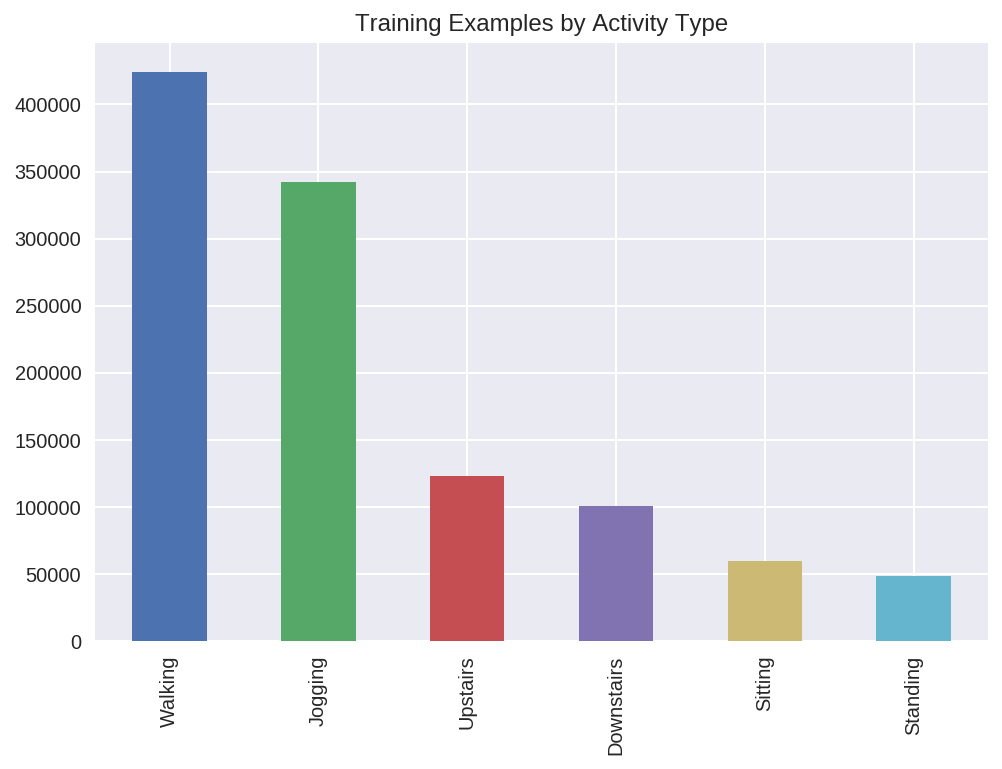

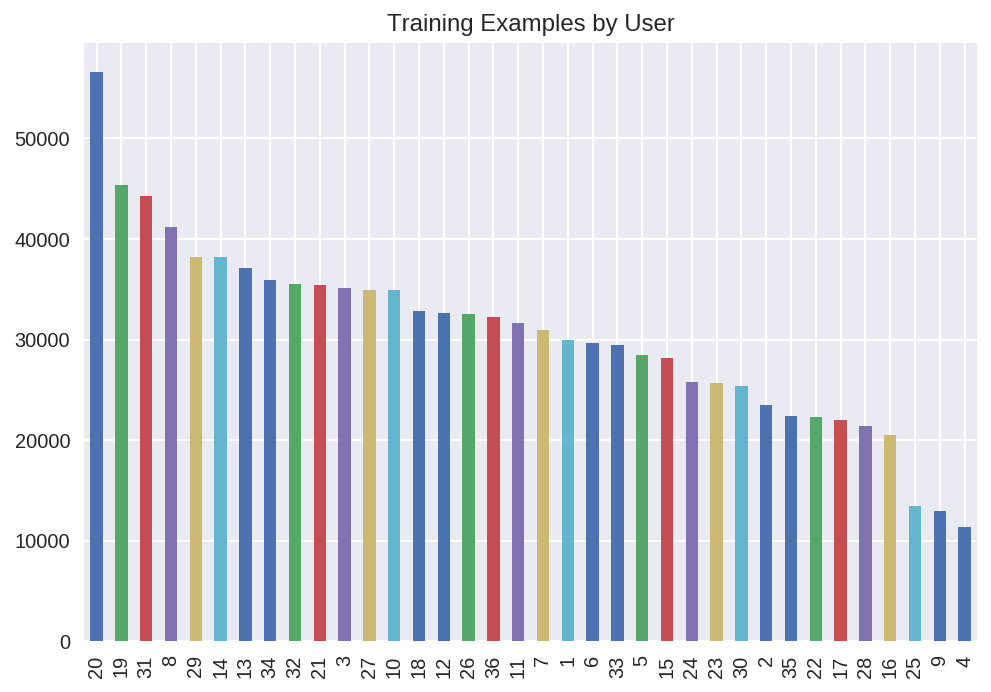

In [10]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                             title='Training Examples by User')
plt.show()

In [11]:
df.shape

(1098203, 6)

In [5]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

In [0]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [0]:
# Define column name of the label vector
# LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df['act'] = le.fit_transform(df['activity'].values)

In [7]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.69,12.68,0.50,1
1,33,Jogging,49106062271000,5.01,11.26,0.95,1
2,33,Jogging,49106112167000,4.90,10.88,-0.08,1
3,33,Jogging,49106222305000,-0.61,18.50,3.02,1
4,33,Jogging,49106332290000,-1.18,12.11,7.21,1


In [9]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [12]:
z = stats.mode(df['act'][0:20])
z[0][0], z[1][0]

(1, 20)

In [13]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [13]:
# df = df[['x-axis', 'y-axis', 'z-axis','ActivityEncoded']]
# df[:5]


,x-axis,y-axis,z-axis,ActivityEncoded
0,-0.694638,12.680544,0.503953,1
1,5.012288,11.264028,0.953424,1
2,4.903325,10.882658,-0.081722,1
3,-0.612916,18.496431,3.023717,1
4,-1.184970,12.108489,7.205164,1


In [0]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [20]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.20,0.79,0.02,1
1,33,Jogging,49106062271000,0.63,0.58,0.11,1
2,33,Jogging,49106112167000,0.61,0.53,-0.10,1
3,33,Jogging,49106222305000,-0.19,1.66,0.55,1
4,33,Jogging,49106332290000,-0.27,0.71,1.42,1


In [0]:
# N = 100
# X_all = []
# y = []
# for i in range(0, len(df)-N+1, N):
#     z = stats.mode(df['act'][i: i+N])
#     action, count = z[0][0], z[1][0]
#     if count == N: # N 샘플이 모두 같은 동작이면
#       x = df[['x-axis','y-axis','z-axis']].values[i: i + N]
#       X_all.append(x)
#       y.append(action)

# X_all = np.asarray(X_all, dtype= np.float32)
# # y = np.asarray(y)

In [24]:
# X_all[0]

(array([[[ -0.6946377 ,  12.680544  ,   0.50395286],
         [  5.012288  ,  11.264028  ,   0.95342433],
         [  4.903325  ,  10.882658  ,  -0.08172209],
         [ -0.61291564,  18.496431  ,   3.0237172 ]],
 
        [[ -1.1849703 ,  12.108489  ,   7.205164  ],
         [  1.3756552 ,  -2.4925237 ,  -6.510526  ],
         [ -0.61291564,  10.56939   ,   5.706926  ],
         [ -0.50395286,  13.947236  ,   7.0553403 ]],
 
        [[ -8.430995  ,  11.413852  ,   5.134871  ],
         [  0.95342433,   1.3756552 ,   1.6480621 ],
         [ -8.19945   ,  19.57244   ,   2.7240696 ],
         [  1.4165162 ,   5.7886477 ,   2.982856  ]],
 
        [[ -1.879608  ,  -2.982856  ,  -0.29964766],
         [ -6.1291566 ,   6.851035  ,  -8.158588  ],
         [  5.829509  ,  18.0061    ,   8.539958  ],
         [  6.2789803 ,   2.982856  ,   2.9147544 ]],
 
        [[ -1.56634   ,   8.308413  ,  -1.4573772 ],
         [  3.5276701 ,  13.593107  ,   9.425281  ],
         [ -2.0294318 ,  -5.706926

In [0]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
N = 100
X_all = []
y = []
for i in range(0, len(df)-N+1, N):
    z = stats.mode(df['act'][i: i+N])
    action, count = z[0][0], z[1][0]
    if count == N:
        xs = df['x-axis'].values[i: i + N]
        ys = df['y-axis'].values[i: i + N]
        zs = df['z-axis'].values[i: i + N]
        X_all.append([xs, ys, zs])
        y.append(action)

    # Bring the segments into a better shape

X_all = np.asarray(X_all, dtype= np.float32)
y = np.asarray(y)

In [0]:
X_3 = np.transpose(X_all, (0,2,1))

In [23]:
# z-axis 성분만 추출
X = X_3[:,:,2]
X[0]

array([ 0.02,  0.11, -0.1 ,  0.55,  1.42, -1.45,  1.11,  1.39,  0.99,
        0.26,  0.48,  0.54, -0.15, -1.79,  1.7 ,  0.52, -0.39,  1.88,
       -2.22, -2.12,  0.23,  0.69, -0.07,  1.27, -1.06,  2.74,  1.2 ,
        0.75,  0.41,  0.9 ,  0.09,  1.74, -0.36,  1.64,  0.1 , -0.22,
        0.75,  0.42, -0.74,  1.28,  0.02,  0.07,  1.62, -0.67,  2.8 ,
        0.19,  1.11,  0.45,  0.33,  0.89, -0.78, -1.74,  0.88,  0.64,
       -0.13,  1.27, -1.  ,  1.11,  1.21,  0.7 , -0.45,  1.23, -1.37,
        0.95,  0.44,  0.83,  0.08,  1.07,  0.35,  1.51,  0.13,  1.26,
        0.21, -1.35, -1.43, -0.14,  0.84,  0.15, -0.66,  1.68, -1.63,
       -0.26, -0.01,  0.65, -0.16,  1.5 , -0.49,  2.9 ,  0.72,  1.07,
        0.38, -0.26,  0.79, -0.99,  2.33,  1.53,  0.68,  0.12, -0.41,
        1.32], dtype=float32)

In [26]:
X.shape, y.shape

((10469, 100), (10469,))

In [25]:
LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

(array([ 883., 3254.,  579.,  465., 1104., 4184.]),
 array([0.  , 0.83, 1.67, 2.5 , 3.33, 4.17, 5.  ]),
 <a list of 6 Patch objects>)

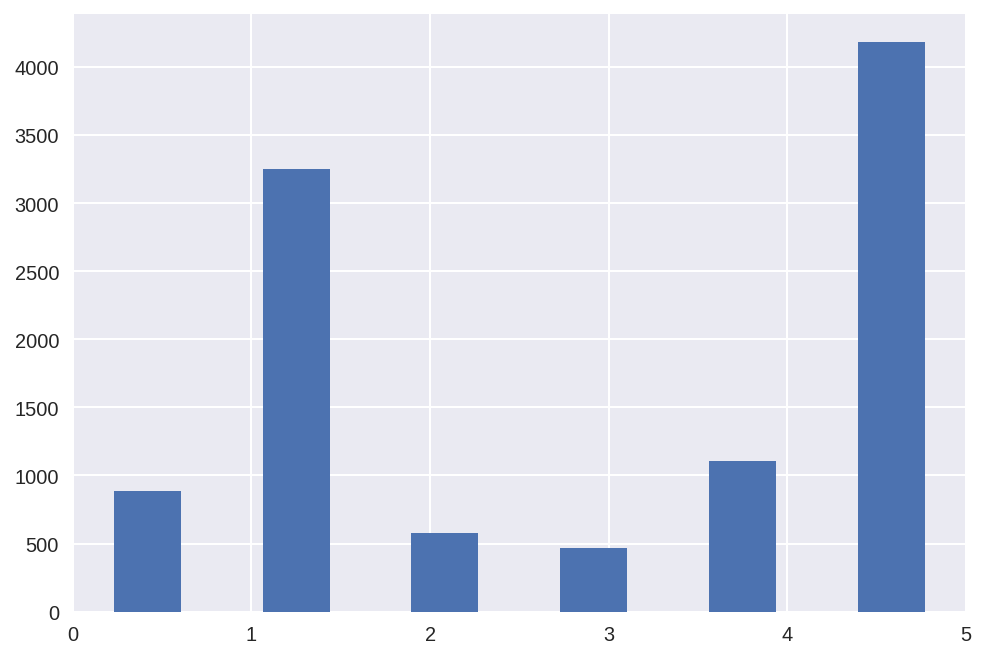

In [27]:
plt.hist(y, bins=6, rwidth=0.45, )

In [0]:
classes = len(df['act'].unique())

In [29]:
y_hot = np_utils.to_categorical(y, classes)
y_hot.shape

(10469, 6)

In [29]:
y_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size = 0.2)
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.62225405921681

In [32]:
X_train.shape, y_train.shape

((8375, 100), (8375, 6))

In [0]:
# rfc = RandomForestClassifier(n_estimators=100) 
# cross_val_score(rfc, X = X, y = y_hot, cv = 5)  

In [30]:
model_m = Sequential()
# model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu', input_shape=(100,)))
# model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
# model_m.add(Flatten())
model_m.add(Dense(classes, activation='softmax'))
print(model_m.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배키 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [35]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 10
EPOCHS = 30

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 6s 865us/step - loss: 0.8680 - acc: 0.6749 - val_loss: 0.6033 - val_acc: 0.7970
Epoch 2/30
6700/6700 [==============================] - 3s 457us/step - loss: 0.5336 - acc: 0.8037 - val_loss: 0.5616 - val_acc: 0.7994
Epoch 3/30
6700/6700 [==============================] - 3s 462us/step - loss: 0.4302 - acc: 0.8445 - val_loss: 0.5434 - val_acc: 0.8096
Epoch 4/30
6700/6700 [==============================] - 3s 462us/step - loss: 0.3537 - acc: 0.8696 - val_loss: 0.5490 - val_acc: 0.8048
Epoch 5/30
6700/6700 [==============================] - 3s 463us/step - loss: 0.2911 - acc: 0.8910 - val_loss: 0.5504 - val_acc: 0.8048
Epoch 6/30
6700/6700 [==============================] - 3s 465us/step - loss: 0.2337 - acc: 0.9160 - val_loss: 0.5902 - val_acc: 0.8119
Epoch 7/30
6700/6700 [==============================] - 3s 456us/step - loss: 0.1886 - a

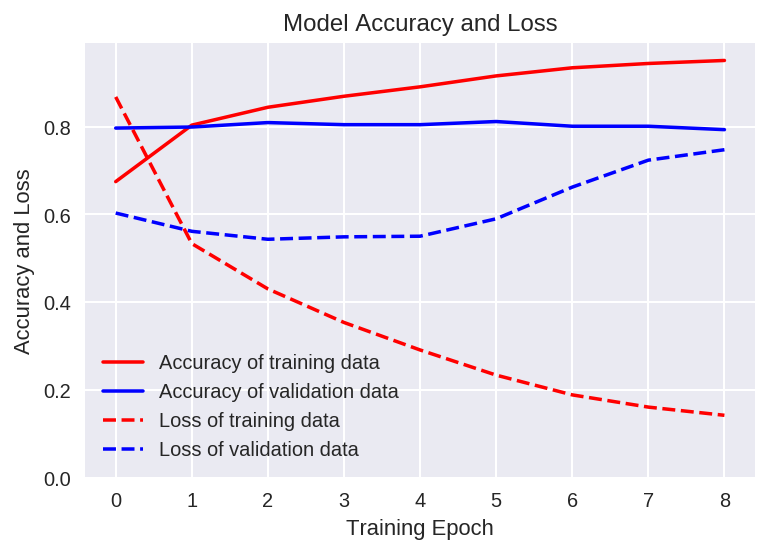

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [0]:
y_pred_train[:3]

In [0]:
np.argmax(y_pred_train[:3], axis=1)

In [0]:
y_train[:3]

In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


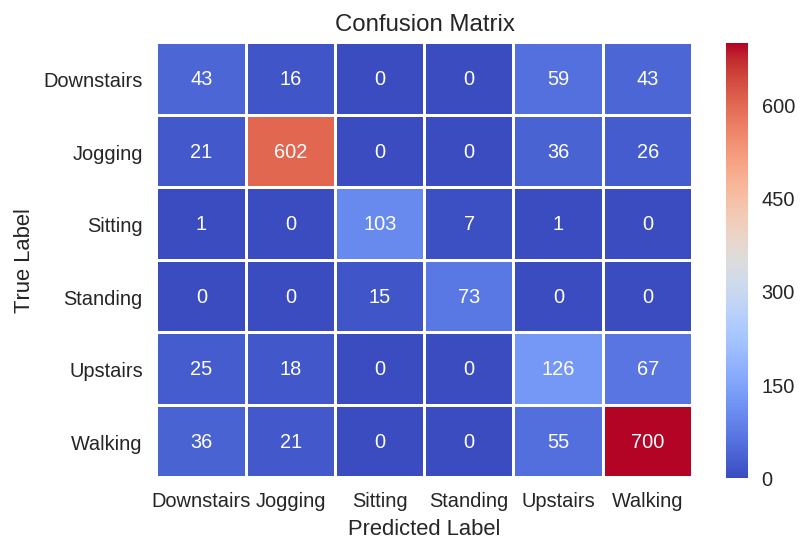

              precision    recall  f1-score   support

           0       0.34      0.27      0.30       161
           1       0.92      0.88      0.90       685
           2       0.87      0.92      0.90       112
           3       0.91      0.83      0.87        88
           4       0.45      0.53      0.49       236
           5       0.84      0.86      0.85       812

   micro avg       0.79      0.79      0.79      2094
   macro avg       0.72      0.72      0.72      2094
weighted avg       0.79      0.79      0.79      2094



In [38]:
y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

## Conv1D를 사용하여 성능을 개선

In [57]:
model_m = Sequential()
model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(N,1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 91, 100)           1100      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 82, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 100)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 18, 160)           160160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 160)               0         
__________

In [40]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 6s 881us/step - loss: 0.7460 - acc: 0.7145 - val_loss: 0.4312 - val_acc: 0.8376
Epoch 2/30
6700/6700 [==============================] - 3s 448us/step - loss: 0.4535 - acc: 0.8281 - val_loss: 0.2945 - val_acc: 0.8925
Epoch 3/30
6700/6700 [==============================] - 3s 451us/step - loss: 0.3755 - acc: 0.8628 - val_loss: 0.2611 - val_acc: 0.8991
Epoch 4/30
6700/6700 [==============================] - 3s 451us/step - loss: 0.3232 - acc: 0.8839 - val_loss: 0.2244 - val_acc: 0.9158
Epoch 5/30
6700/6700 [==============================] - 3s 452us/step - loss: 0.2714 - acc: 0.8999 - val_loss: 0.2247 - val_acc: 0.9182
Epoch 6/30
6700/6700 [==============================] - 3s 453us/step - loss: 0.2528 - acc: 0.9048 - val_loss: 0.2246 - val_acc: 0.9122
Epoch 7/30
6700/6700 [==============================] - 3s 453us/step - loss: 0.2227 - acc: 0.9190 - val_loss: 0.2285 - val_acc: 0.9176


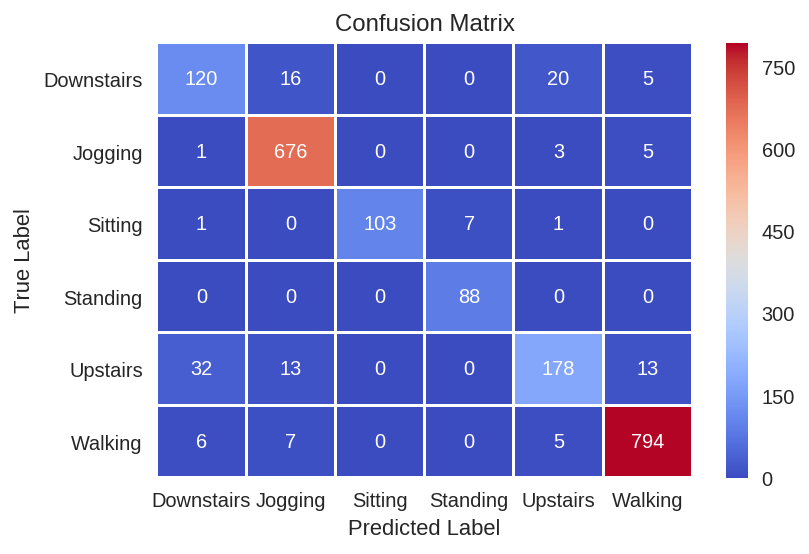

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       161
           1       0.95      0.99      0.97       685
           2       1.00      0.92      0.96       112
           3       0.93      1.00      0.96        88
           4       0.86      0.75      0.80       236
           5       0.97      0.98      0.97       812

   micro avg       0.94      0.94      0.94      2094
   macro avg       0.91      0.90      0.90      2094
weighted avg       0.93      0.94      0.93      2094



In [41]:
y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# RNN으로 학습

In [43]:
from keras.layers import GRU
model = Sequential()
model.add(Reshape((N,1), input_shape=(N,)))
model.add(GRU(256, return_sequences=True, input_shape=(N,1)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 256)          198144    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 593,670
Trainable params: 593,670
Non-trainable params: 0
_________________________________________________________________


Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 121s 18ms/step - loss: 0.9903 - acc: 0.6169 - val_loss: 0.6896 - val_acc: 0.7469
Epoch 2/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.5601 - acc: 0.7919 - val_loss: 0.3438 - val_acc: 0.8746
Epoch 3/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.4258 - acc: 0.8442 - val_loss: 0.4501 - val_acc: 0.8466
Epoch 4/30
6700/6700 [==============================] - 119s 18ms/step - loss: 0.3476 - acc: 0.8742 - val_loss: 0.3209 - val_acc: 0.8860
Epoch 5/30
6700/6700 [==============================] - 119s 18ms/step - loss: 0.3004 - acc: 0.8907 - val_loss: 0.2327 - val_acc: 0.9194
Epoch 6/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.2663 - acc: 0.9027 - val_loss: 0.2291 - val_acc: 0.9164
Epoch 7/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.2233 - acc: 0.9201 - val_loss: 0.2760 - val_acc: 

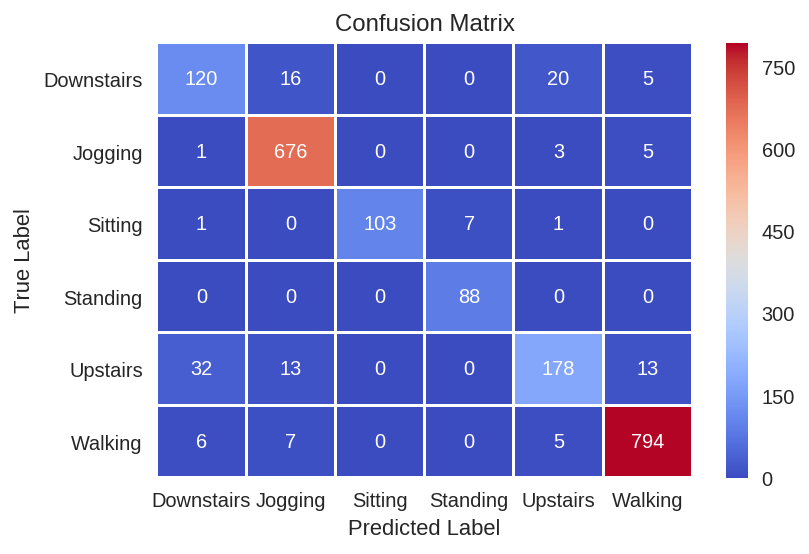

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       161
           1       0.95      0.99      0.97       685
           2       1.00      0.92      0.96       112
           3       0.93      1.00      0.96        88
           4       0.86      0.75      0.80       236
           5       0.97      0.98      0.97       812

   micro avg       0.94      0.94      0.94      2094
   macro avg       0.91      0.90      0.90      2094
weighted avg       0.93      0.94      0.93      2094



In [45]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z 모두 사용할 때(Conv1D)

In [31]:
X_3.shape

(10469, 100, 3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_hot, test_size = 0.2)

In [0]:
#### 아래 reshape 부분??

In [36]:
model_m = Sequential()
# model_m.add(Reshape((3,N,1), input_shape=(3,N,)))
model_m.add(Conv1D(64, 10, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
# model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(classes, activation='softmax'))
print(model_m.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 91, 64)            1984      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 82, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 128)           82048     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
___________________________

In [37]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 8s 1ms/step - loss: 0.6012 - acc: 0.7810 - val_loss: 0.3214 - val_acc: 0.8782
Epoch 2/30
6700/6700 [==============================] - 3s 407us/step - loss: 0.2739 - acc: 0.9028 - val_loss: 0.1613 - val_acc: 0.9558
Epoch 3/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.1696 - acc: 0.9425 - val_loss: 0.1454 - val_acc: 0.9546
Epoch 4/30
6700/6700 [==============================] - 3s 405us/step - loss: 0.1324 - acc: 0.9566 - val_loss: 0.1040 - val_acc: 0.9666
Epoch 5/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.0954 - acc: 0.9701 - val_loss: 0.0905 - val_acc: 0.9719
Epoch 6/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.0862 - acc: 0.9737 - val_loss: 0.0872 - val_acc: 0.9719
Epoch 7/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.0638 - acc

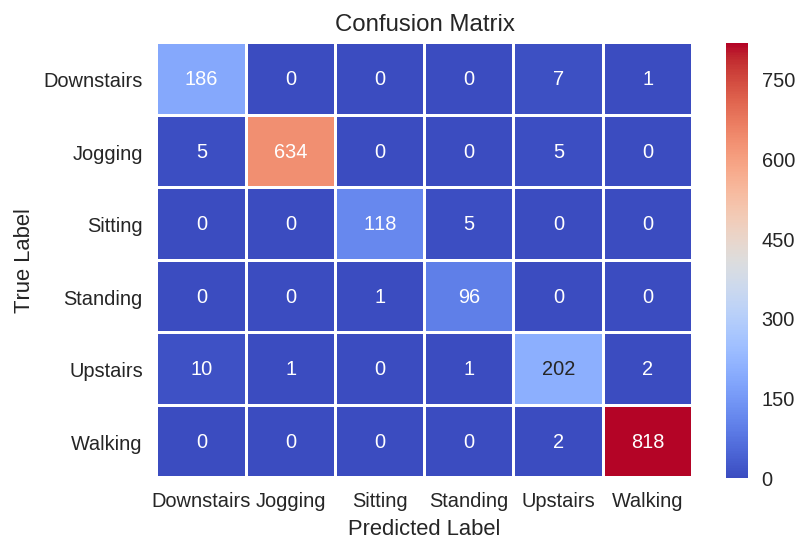

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       194
           1       1.00      0.98      0.99       644
           2       0.99      0.96      0.98       123
           3       0.94      0.99      0.96        97
           4       0.94      0.94      0.94       216
           5       1.00      1.00      1.00       820

   micro avg       0.98      0.98      0.98      2094
   macro avg       0.96      0.97      0.97      2094
weighted avg       0.98      0.98      0.98      2094



In [40]:
y_pred_test = model_m.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z, RNN

In [45]:
from keras.layers import GRU
model = Sequential()
# model.add(Reshape((N,3), input_shape=(N,3)))
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 100, 256)          199680    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1542      
Total params: 595,206
Trainable params: 595,206
Non-trainable params: 0
_________________________________________________________________


Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 118s 18ms/step - loss: 0.7806 - acc: 0.7310 - val_loss: 0.5711 - val_acc: 0.8275
Epoch 2/30
6700/6700 [==============================] - 117s 17ms/step - loss: 0.3364 - acc: 0.8785 - val_loss: 0.2413 - val_acc: 0.9170
Epoch 3/30
6700/6700 [==============================] - 117s 17ms/step - loss: 0.1986 - acc: 0.9337 - val_loss: 0.2065 - val_acc: 0.9325
Epoch 4/30
6700/6700 [==============================] - 116s 17ms/step - loss: 0.1323 - acc: 0.9570 - val_loss: 0.1035 - val_acc: 0.9588
Epoch 5/30
6700/6700 [==============================] - 116s 17ms/step - loss: 0.0894 - acc: 0.9706 - val_loss: 0.1332 - val_acc: 0.9534
Epoch 6/30
6700/6700 [==============================] - 116s 17ms/step - loss: 0.0802 - acc: 0.9728 - val_loss: 0.1753 - val_acc: 0.9534
Epoch 7/30
6700/6700 [==============================] - 117s 17ms/step - loss: 0.0495 - acc: 0.9819 - val_loss: 0.0728 - val_acc: 

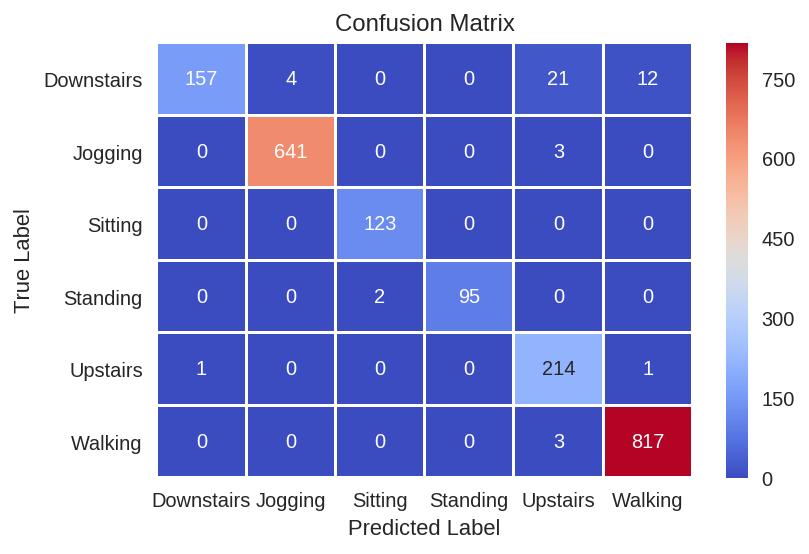

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       194
           1       0.99      1.00      0.99       644
           2       0.98      1.00      0.99       123
           3       1.00      0.98      0.99        97
           4       0.89      0.99      0.94       216
           5       0.98      1.00      0.99       820

   micro avg       0.98      0.98      0.98      2094
   macro avg       0.97      0.96      0.97      2094
weighted avg       0.98      0.98      0.98      2094



In [46]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))